First part is the  list of movie reviews from HW7 

In [1]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from bs4 import BeautifulSoup
from requests import get

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd


url = 'https://www.imdb.com/list/ls095374765/?sort=moviemeter,asc&st_dt=&mode=grid&page=1&ref_=ttls_vw_smp&genres=Comedy'
response = get(url)
html_soupMain = BeautifulSoup(response.text, 'html.parser')

In [2]:
movieReview = []
reviewTitle = []
movieTitle = []

In [3]:
def list_Of_Reviews(website):
    soup = BeautifulSoup(website, 'html.parser')

    f = soup.find_all('div', class_='ipl-icon ipl-star-icon')
    f = soup.find_all('span', class_="rating-other-user-rating")#.find('span').text

    idxPos = -1
    idxNeg = -1

    for idx, i in enumerate(f):
        sp = (f[idx].text.split('/'))
        sp = int(sp[0][-2:])
        if sp > 8:
            idxPos = idx
        elif sp < 4:
            idxNeg = idx
    return([idxNeg,idxPos])

In [4]:
stop_words = set(stopwords.words("english"))
for div in html_soupMain.findAll('div', attrs={'class':'title'}):
    if len(movieReview) > 98:
        break
    else:
        url = 'https://www.imdb.com' + div.find('a')['href'] 
        url = url + 'reviews'
        response = get(url)
        html_soup = BeautifulSoup(response.text, 'html.parser')
        review_containers = html_soup.find_all('div', class_='text show-more__control')
        title_containers = html_soup.find_all( class_='title')
        
        reviewIndex = list_Of_Reviews(response.content)
        reviewList = []
        if reviewIndex[0] == -1 or reviewIndex[1] == -1:
            pass
        else:
            reviewList.append(review_containers[reviewIndex[0]].text)
            reviewList.append(review_containers[reviewIndex[1]].text)
            reviewTitle.append(title_containers[reviewIndex[0]].string + ' -')
            reviewTitle.append(title_containers[reviewIndex[1]].string + ' +')
            movieTitle.append(div.string + ' -')
            movieTitle.append(div.string + ' +')
            count =+ 2
            for i in reviewList:
                review = i.lower()
                #remove punctuation
                review = re.sub('[^a-zA-Z]', ' ', review)
                
                #remove tags
                review = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",review)

                #remove special characters and digits
                review = re.sub("(\\d|\\W)+"," ",review)

                split_text = review.split()
                
                #Lemmatize
                lem = WordNetLemmatizer()
                split_text = [lem.lemmatize(word) for word in split_text if not word in stop_words and len(word) >2] 
                split_text = " ".join(split_text)
                movieReview.append(split_text)

In [5]:
print(len(movieReview))

100


#### 1.	In Python, load one of the sentiment vocabularies referenced in the textbook, and run the sentiment analyzer as explained in the corresponding reference. Add words to the sentiment vocabulary, if you think you need to, to better fit your particular text collection.

In [6]:
#I am going to use TfidfVectorizer this time
vectorizer = TfidfVectorizer(stop_words={'english'})
movieList_v = vectorizer.fit_transform(movieReview)

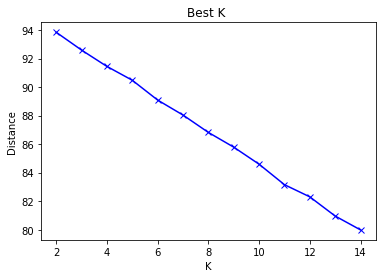

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
X = movieList_v
K = range(2,15)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('K')
plt.ylabel('Distance')
plt.title('Best K ')
plt.show()

It  looks to me that 10 clusters seem to be the point  that works the best. 

In [8]:
k = 10
model = KMeans(n_clusters=k, max_iter=200, n_init=10, tol = 0.001)
mod_8 = model.fit(X)
labels=model.labels_

review_clusters = pd.DataFrame(list(zip(movieTitle, labels)),columns=['Movie Title','Cluster'])
print(review_clusters.sort_values(by=['Cluster']))

                                   Movie Title  Cluster
49                       Hobo with a Shotgun +        0
43                               Wagons East +        0
45  The SpongeBob Movie: Sponge Out of Water +        0
48                       Hobo with a Shotgun -        0
50                                 The House -        0
..                                         ...      ...
55                                   Hatchet +        9
73                            Victor Crowley +        9
72                            Victor Crowley -        9
94                                  Blankman -        9
67                 The Return of Swamp Thing +        9

[100 rows x 2 columns]


In [9]:
often_words = mod_8.cluster_centers_.argsort()[:,-1:-10:-1]

word_features = vectorizer.get_feature_names()

for cluster_group, centroid in enumerate(often_words):
    print(f"Cluster {cluster_group}: {', '.join(word_features[word] for word in centroid)}")

Cluster 0: movie, one, see, hobo, really, made, great, actor, like
Cluster 1: first, get, like, boring, film, alien, good, sequel, classic
Cluster 2: movie, scene, john, laughing, laughed, comedy, candy, good, biography
Cluster 3: money, film, watch, potty, actually, funny, people, version, zorro
Cluster 4: cartoon, gadget, film, lot, thought, liked, entertaining, movie, nice
Cluster 5: kid, spy, film, movie, like, good, science, old, adult
Cluster 6: thurman, uma, power, girlfriend, wood, super, matt, shoot, eddie
Cluster 7: fan, rock, song, honestly, titan, lego, enjoy, pootie, clever
Cluster 8: spongebob, zoom, minute, could, actual, first, attempt, fart, ttgo
Cluster 9: still, gore, one, hatchet, victor, humour, crowley, franchise, made


In [10]:
result={'cluster':labels,'Movie Reviews':movieReview}
result=pd.DataFrame(result)

In [11]:
#using the vader lexicon from NLTK
nltk.download('vader_lexicon')



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jjose\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
from nltk.sentiment import SentimentIntensityAnalyzer
SentiAnalyzer = SentimentIntensityAnalyzer()

stopWords = stopwords.words("english")
stopWords.extend([w.lower() for w in nltk.corpus.names.words()])

In [13]:
from statistics import mean, median
def polarity_score(review):
    scores = [
      SentiAnalyzer.polarity_scores(sentence)["compound"]
        for sentence in [w for w in nltk.sent_tokenize(review) if not w in stopWords]
    ]
    return mean(scores)
#emaple of polartiy
polarity_score('THe weather outside was great')

0.6249

In [14]:
SentimentScore = []
for review in movieReview:
    score = polarity_score(review)
    SentimentScore.append(score)

result['Score'] = SentimentScore
print(result)

    cluster                                      Movie Reviews   Score
0         3     save money watch disney version robin williams  0.4939
1         4  aladdin latest disney remake based animated fi...  0.9939
2         5  sure weird science spectacular film never ment...  0.9892
3         2  one favorite john hughes movie happily marries...  0.9716
4         0  comedy funny guess soon deed done much left ca...  0.7430
..      ...                                                ...     ...
95        0  movie great always thought damon wayans funny ...  0.9973
96        0  hard recommend movie beyond general nostalgia ... -0.4627
97        2  motley collection petrolheads compete illegal ...  0.8484
98        3  straight filming sea release onvhs bargain bin...  0.4019
99        2  laughed hard many time watching movie wrong re...  0.8689

[100 rows x 3 columns]


#### Vader was used to help  with the senitment analysis . It come from the  NLTK  pakage, It is good with smaller text sizes like this , and can be more causal than ther  other methods.

## 2.	For each of the clusters you created in homework 7, compute the average, median, high, and low sentiment scores for each cluster. Explain whether you think this reveals anything interesting about the clusters.



In [15]:
cluster_Scores = result[['cluster','Score']]
cluster_Group_Scores = cluster_Scores.groupby("cluster").agg({'Score': ['mean', 'median', 'min', 'max']})
print(cluster_Group_Scores)

            Score                         
             mean   median     min     max
cluster                                   
0        0.498152  0.88090 -0.9726  0.9973
1        0.387973  0.71840 -0.9678  0.9983
2        0.863343  0.96435 -0.2263  0.9954
3        0.486600  0.78895 -0.7414  0.9909
4        0.739400  0.99045 -0.9406  0.9945
5        0.422273  0.94000 -0.9805  0.9892
6        0.962800  0.98350  0.8910  0.9932
7        0.688520  0.72690  0.3213  0.8860
8       -0.229520 -0.81760 -0.9531  0.9021
9        0.901471  0.94670  0.6597  0.9805


Here we can see all the different types of clusters that have been forming. We can see that many  of these reviews are in fact on the positive side in general. Out  of these 10  clusters you can see that it  is mostly positive in general . The  only cluster that was negative is the  cluster number 2. By  using vader  and  clustering it  allows us to identify groups  that have similar feelings. 